In [1]:
## Requerimientos
## tf.__version__ que sea 2.6.2

# !pip  install transformers==4.5.1 -q

# CUDA
# Cuda compilation tools, release 11.2, V11.2.67
# Build cuda_11.2.r11.2/compiler.29373293_0

In [2]:
import transformers

C:\Users\CLIENTE\anaconda3\envs\cuda_ambientesu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tensorflow as tf
import keras
import pandas as pd
import json
import gc

import numpy as np

from tqdm import tqdm

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers.utils import logging

#from transformers import TextClassificationPipeline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
    
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot



Cerciorarse que estemos usando el GPU, debemos tener cuda instalado

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


Ubicarse en el lugar donde se tenga la data

In [7]:
cd F:\Maestria\TESIS\

F:\Maestria\TESIS


In [8]:
df= pd.read_csv('./BD_POL/political_social_media.csv', encoding='iso-8859-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


In [9]:
df.shape

(5000, 21)

### Limpieza

In [10]:
df_w = df[["bias", "text"]]

In [11]:
df_w['text'] = df_w['text'].str.lower()

C:\Users\CLIENTE\anaconda3\envs\cuda_ambientesu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
df_w["text"] = df_w["text"].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()

C:\Users\CLIENTE\anaconda3\envs\cuda_ambientesu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
df_w['text'] = df_w['text'].str.replace(
    r'[^a-z0-9\s]',
    '',
    regex=True,
    flags=re.IGNORECASE
)

C:\Users\CLIENTE\anaconda3\envs\cuda_ambientesu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_w.head()

,bias,text
0,partisan,rt nowthisnews rep trey radel r fl slams obama...
1,partisan,video obamacare full of higher costs and bro...
2,neutral,please join me today in remembering our fallen...
3,neutral,rt senatorleahy 1st step toward senate debate ...
4,partisan,amazon delivery drones show need to update law...


Observamos un poco de CLASS_IMBALANCE

<Figure size 576x576 with 0 Axes>

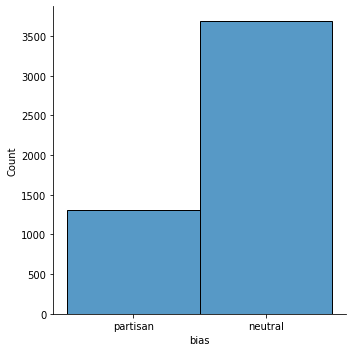

In [22]:
plt.figure(figsize= (8, 8))

sns.displot(df_w['bias'])
#df_w.bias.value_counts().plot(kind='pie', figsize=(5,5))
plt.show()

#### Reducimos un poco la clase mayoritaria

In [23]:
df_w.sort_values("bias", inplace=True)
df_w = df_w.reset_index(drop=True)

C:\Users\CLIENTE\anaconda3\envs\cuda_ambientesu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
### Dropeamos varias ROWS con CLASE = NEUTRA, para emparejar
df_w = df_w.iloc[500:,:]

<Figure size 576x576 with 0 Axes>

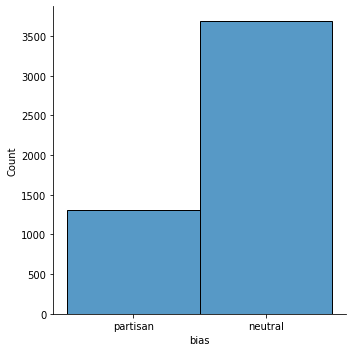

In [26]:
plt.figure(figsize= (8, 8))

sns.displot(df_w['bias'])
#df_w.bias.value_counts().plot(kind='pie', figsize=(5,5))
plt.show()

Ahora son menos, y las clases son más parejas

### Conteo de palabras

In [27]:
df_w['count'] = df_w['text'].apply(lambda x: len(x.split()))

C:\Users\CLIENTE\anaconda3\envs\cuda_ambientesu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
df_w.head()

,bias,text,count
0,partisan,rt nowthisnews rep trey radel r fl slams obama...,10
1,partisan,video obamacare full of higher costs and bro...,9
2,neutral,please join me today in remembering our fallen...,22
3,neutral,rt senatorleahy 1st step toward senate debate ...,20
4,partisan,amazon delivery drones show need to update law...,19


In [29]:
df_w.shape

(5000, 3)

In [30]:
# SHUFFLING el dataset
df_w = df_w.sample(frac=1, random_state = 1).reset_index(drop=True)

In [31]:
df_w.tail()

,bias,text,count
4995,neutral,wishing everyone a safe and happy thanksgiving...,23
4996,neutral,yesterday honor flight brought a group of idah...,25
4997,partisan,spoonboy42 not closing door on foreigners i su...,22
4998,neutral,last night we lost americas most beloved gospe...,54
4999,neutral,a great lunch at hotel congress in tucson one...,16


In [32]:
df_w.describe()

,count
count,5000.000000
mean,30.970200
std,51.051407
min,0.000000
25%,15.000000
50%,19.000000
75%,32.000000
max,2595.000000


In [33]:
df_w.dtypes

bias     object
text     object
count     int64
dtype: object

In [34]:
## Botamos las rows que tengan demasiadas palabras que llenan la memoria.
df_w.drop(df_w[(df_w['count'] >100)].index, inplace=True)

In [35]:
df_w.describe()

,count
count,4822.000000
mean,25.568436
std,18.751914
min,0.000000
25%,15.000000
50%,19.000000
75%,29.000000
max,100.000000


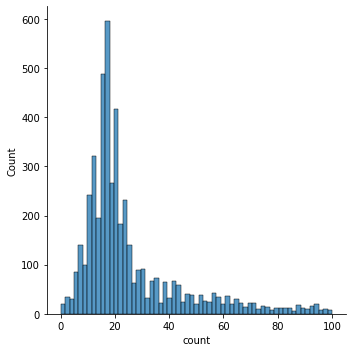

In [36]:
sns.displot(df_w['count'])

### Label Encode

In [37]:
encoder = LabelEncoder()

df_w["bias"] = encoder.fit_transform(df_w["bias"])
df_w.head(4)

,bias,text,count
1,0,after finding out a 29yearold contractor leake...,31
2,0,thank you to carlos urias director of military...,46
3,1,the housepassed solution would tie student loa...,28
5,0,i am frustrated with the lack of action or acc...,65


In [38]:
encoder.classes_  ## 0 neutral, 1 partisan

array(['neutral', 'partisan'], dtype=object)

In [39]:
data_texts = df_w['text'].to_list()

data_labels = df_w['bias'].to_list()

In [40]:
len(data_labels)

4822

In [41]:
df_w.shape

(4822, 3)

### Train Test Split

In [47]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts,
                                                                    data_labels,
                                                                    test_size = 0.2,
                                                                    #random_state = 0, ) ## Shuffle
                                                                    stratify = data_labels)

val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts,
                                                                  val_labels,
                                                                  test_size = 0.4,
                                                                  #random_state = 0, ) ## Shuffle del dS
                                                                  stratify = val_labels )

## TOKENIZAR

In [48]:
## Usamos DISTILBERT para tokenizar el DS
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

## Tokenizamos los Datasets
train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

test_encodings = tokenizer(test_texts, truncation = True, padding = True )

#### Convertimos a tensores

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

### Hacemos el Fine-tuning con el TFTrainer class

In [50]:
from transformers import TFTrainer, TFTrainingArguments

https://discuss.huggingface.co/t/import-error-while-loading-a-fine-tuned-distilbert-model/28615

### Argumentos del TRAINING

In [51]:

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    max_steps = 400,  # --- > Si no colocamos 400 steps, da error con el "lr_scheduler"
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=1e-4,
    logging_dir='./logs',
    eval_steps=25, 
    learning_rate = 0.005,
    lr_scheduler_type = "constant_with_warmup"
)

# max_steps = 500, Da error

In [52]:
# model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
#                                                              num_labels=2)istilbert-base-uncased',

In [53]:
import tensorflow as tf
from tensorflow.compat.v1 import RunOptions

run_options = RunOptions(report_tensor_allocations_upon_oom=True)

In [54]:
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                                          num_labels = 2 )
    #trainer_model.compile(loss = "...", optimizer = "...", metrics = "..", options = run_opts)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [55]:
trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [56]:
trainer.optimizer = tf.keras.optimizers.SGD()

In [57]:
logging.set_verbosity_info()
logger = logging.get_logger("transformers")
logger.info("INFO")
logger.warning("WARN")

INFO
WARN


In [58]:
trainer.train()

# Toma 3 min 36 secs hacer el training

***** Running training *****
  Num examples = 3857
  Num Epochs = 2.0
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Steps per epoch = 242
  Total optimization steps = 400


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x00000196EEFDFA08> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x00000196EEFDFA08> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



Training took: 0:04:24.033476


In [59]:
# Evaluamos
# Eval_loss sale bastante grande
trainer.evaluate()

***** Running Evaluation *****
  Num examples in dataset = 579
  Num examples in used in evaluation = 608
  Batch size = 32


{'eval_loss': 0.4511048166375411, 'epoch': 1.6528925619834711, 'step': 400}


{'eval_loss': 0.4511048166375411}

#### Guardamos el modelo

In [60]:
save_directory = "GUARDADO/"

trainer_model.save_pretrained(save_directory)
# model.save_pretrained(save_directory)  ---> La verdad no se que modelo va.

tokenizer.save_pretrained(save_directory)

Configuration saved in GUARDADO/config.json
Model weights saved in GUARDADO/tf_model.h5
tokenizer config file saved in GUARDADO/tokenizer_config.json
Special tokens file saved in GUARDADO/special_tokens_map.json


('GUARDADO/tokenizer_config.json',
 'GUARDADO/special_tokens_map.json',
 'GUARDADO/vocab.txt',
 'GUARDADO/added_tokens.json')

#### Cargamos el modelo pre-entrenado

In [10]:
# ## Para cargar nos ubicamos en la carpeta
# cd F:\Maestria\TESIS\

In [61]:
save_directory = "GUARDADO/"

tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Didn't find file GUARDADO/added_tokens.json. We won't load it.
Didn't find file GUARDADO/tokenizer.json. We won't load it.
loading file GUARDADO/vocab.txt
loading file None
loading file GUARDADO/special_tokens_map.json
loading file GUARDADO/tokenizer_config.json
loading file None
loading configuration file GUARDADO/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.5.1",
  "vocab_size": 30522
}

loading weights file GUARDADO/tf_model.h5
Some layers from the model checkpoint at GUARDADO/ were not used when initi

In [62]:
test_text = test_texts[6]

test_text

'great to see ranchocordova mayor linda budge amp other city leaders in dc good talk on improving local transit'

In [63]:
len(test_texts)

386

In [64]:
val_text = val_texts[2]

val_text

'last week i was honored to speak at the 41st march for life it was an amazing experience to talk about the importance of life with so many from around the country'

In [65]:
## 0 neutral |||  1 partisan

predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

outputs = model_fine_tuned(predict_input)
output = model_fine_tuned(predict_input)[0]

logits = outputs.logits

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

## Aplicamos softmax al Logits para obtener el SCORE
probabilities = tf.nn.softmax(logits)
print(logits)
print(probabilities)

prediction_value

tf.Tensor([[ 1.4717295 -1.3334217]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.9429535  0.05704645]], shape=(1, 2), dtype=float32)


0

In [66]:
output
# Tensor con la predicción

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 1.4717295, -1.3334217]], dtype=float32)>

In [67]:
predict_input = tokenizer_fine_tuned.encode(
    val_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value

0

In [68]:
output

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 1.6682148, -1.5797607]], dtype=float32)>

### Prueba

In [71]:
# Tokenizo
test_encodings = tokenizer_fine_tuned(test_texts, truncation = True, padding = True )

In [72]:
# Convertimos a Tensores
Test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [73]:
range(len(test_texts))

range(0, 386)

In [74]:
## Tokeznizar y tensorizar en un proceso
Lista_tensores = []

for i in range(len(test_texts)):
    predict_input = tokenizer_fine_tuned.encode(
        test_texts[i],
        truncation = True,
        padding = True,
        return_tensors = 'tf'
    )
    Lista_tensores.append(predict_input)

In [75]:
lista_predichos = []
for i in range(len(Lista_tensores)):
    test_pred = model_fine_tuned.predict(Lista_tensores[i])
    lista_predichos.append(test_pred)

In [76]:
len(lista_predichos)

386

In [77]:
lista_predicho_label = []

for i in range(len(lista_predichos)):
    prediction_values = tf.argmax(lista_predichos[i][0], axis = 1).numpy()[0]
    
    lista_predicho_label.append(prediction_values)
    

In [78]:
lista_predicho_label

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,


In [79]:
# Softmax para ver el SCORE de cada prediccion
tf.nn.softmax(lista_predichos[0][0])[0][1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.09348022>

In [80]:
lista_scores = []

for i in range(len(lista_predichos)):
    probabilities = tf.nn.softmax(lista_predichos[i][0])
        
    lista_scores.append([probabilities[0][0],probabilities[0][1]])

In [81]:
lista_scores[14]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.91287625>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.087123744>]

In [82]:
# Obtenemos la lista de
lista_v = []

for i in range(180):    
    x1 = lista_scores[i][0].numpy()
    x2 = lista_scores[i][1].numpy()
    #print(x)
    if x1 > 0.82:
        y = i    
        lista_v.append([x1,y])
    elif x2 > 0.6:
        y = i    
        lista_v.append([x2,y])

In [83]:
lista_v

# El número de la izq es el score, el de la derecha el ÍNDICE en el cual se encuentra la predicción (0,1)
## Esto lo hago porque sólo quiero ver la explciación en el SHAP, las predicciones con un score alto.
### Pero, resulta que, las predicciones con un SCORE alto, solamente son 0's

[[0.90651983, 0],
 [0.9175376, 4],
 [0.8524672, 5],
 [0.9429535, 6],
 [0.9563944, 7],
 [0.9558713, 9],
 [0.91660845, 10],
 [0.9572911, 13],
 [0.91287625, 14],
 [0.94406635, 15],
 [0.9409555, 16],
 [0.94214135, 17],
 [0.94743526, 18],
 [0.9444275, 19],
 [0.6367897, 21],
 [0.9509936, 23],
 [0.9519523, 24],
 [0.95128065, 27],
 [0.87314826, 28],
 [0.95533395, 29],
 [0.6449154, 30],
 [0.956305, 31],
 [0.9617237, 32],
 [0.89325035, 33],
 [0.94427216, 36],
 [0.9463713, 38],
 [0.93992615, 39],
 [0.9353188, 41],
 [0.95422345, 43],
 [0.95353174, 44],
 [0.85831416, 49],
 [0.91823614, 51],
 [0.90495765, 52],
 [0.6097153, 54],
 [0.93583596, 58],
 [0.95227015, 59],
 [0.953832, 60],
 [0.9555984, 62],
 [0.91341996, 63],
 [0.9561439, 65],
 [0.9152125, 66],
 [0.68130314, 68],
 [0.6820394, 69],
 [0.95273435, 70],
 [0.954574, 71],
 [0.8985262, 72],
 [0.87046957, 75],
 [0.84294367, 76],
 [0.84302413, 80],
 [0.94421107, 81],
 [0.9598019, 82],
 [0.60496974, 83],
 [0.9405121, 84],
 [0.9596195, 85],
 [0.953496

In [84]:
print(lista_v)

[[0.90651983, 0], [0.9175376, 4], [0.8524672, 5], [0.9429535, 6], [0.9563944, 7], [0.9558713, 9], [0.91660845, 10], [0.9572911, 13], [0.91287625, 14], [0.94406635, 15], [0.9409555, 16], [0.94214135, 17], [0.94743526, 18], [0.9444275, 19], [0.6367897, 21], [0.9509936, 23], [0.9519523, 24], [0.95128065, 27], [0.87314826, 28], [0.95533395, 29], [0.6449154, 30], [0.956305, 31], [0.9617237, 32], [0.89325035, 33], [0.94427216, 36], [0.9463713, 38], [0.93992615, 39], [0.9353188, 41], [0.95422345, 43], [0.95353174, 44], [0.85831416, 49], [0.91823614, 51], [0.90495765, 52], [0.6097153, 54], [0.93583596, 58], [0.95227015, 59], [0.953832, 60], [0.9555984, 62], [0.91341996, 63], [0.9561439, 65], [0.9152125, 66], [0.68130314, 68], [0.6820394, 69], [0.95273435, 70], [0.954574, 71], [0.8985262, 72], [0.87046957, 75], [0.84294367, 76], [0.84302413, 80], [0.94421107, 81], [0.9598019, 82], [0.60496974, 83], [0.9405121, 84], [0.9596195, 85], [0.9534965, 86], [0.93264246, 87], [0.8338298, 88], [0.60174257

### Verificacion de SCORES DE LABEL 1

In [85]:
## Estoy verificando cuál es el score "promedio" que se le da a cada valor predicho como "1"
## Para eso hago una lista de verificar scores, donde agarro solo los valores predichos como "1"

lista_verificar_scores = []

for i in range(len(lista_predichos)):
    if lista_predicho_label[i] == 1:
        lista_verificar_scores.append([lista_predicho_label[i],i])        
    else:
        pass

In [86]:
## teniendo esta lista, hago otra lista_scores_verificacion, donde meteré los SCORES de los valores con prediccion = "1"
## y si está bien, verifico que los valores que fueron predichos como 1's, son valores bajos.

lista_scores_verificacion = []

for i in range(len(lista_verificar_scores)):
    z = lista_verificar_scores[i][1]
    #z_1 = lista_predichos[i][z]
    probabilities_verificacion = tf.nn.softmax(lista_predichos[z][0])
        
    lista_scores_verificacion.append([probabilities_verificacion[0][0],probabilities_verificacion[0][1]])

In [87]:
lista_p = []
for i in range(len(lista_scores_verificacion)):
    p = lista_scores_verificacion[i][1].numpy()
    lista_p.append(p)


In [88]:
import statistics as stat

print(np.mean(lista_p))
print(np.percentile(lista_p, 25))
print(np.percentile(lista_p, 50))
print(np.percentile(lista_p, 75))

# Confirmo que si son valores bajos los labels "1"
# Tiene sentido porque es la CLASE MINORITARIA

0.5917447
0.5524817705154419
0.5893060564994812
0.6307239532470703


##### Termina la verificación

In [89]:
lista_v2 = []
for i in lista_v:
    x = i[1]
    lista_v2.append(x)

In [90]:
print(lista_v2)

[0, 4, 5, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 27, 28, 29, 30, 31, 32, 33, 36, 38, 39, 41, 43, 44, 49, 51, 52, 54, 58, 59, 60, 62, 63, 65, 66, 68, 69, 70, 71, 72, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 94, 95, 97, 100, 101, 103, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 133, 134, 136, 137, 138, 140, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 166, 169, 170, 172, 174, 175, 177, 178, 179]


In [91]:
lista_v3 = []
for i in lista_v2:
    x = lista_predicho_label[i]    
    lista_v3.append(x)

In [92]:
print(lista_v3)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]


### Matriz de Confusion

[[259  27]
 [ 58  42]]


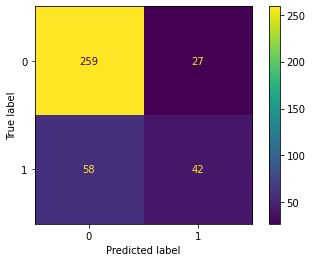

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy

# Create a confusion matrix
conf_mat = confusion_matrix(test_labels, lista_predicho_label)

# Print the confusion matrix
print(conf_mat)

confusion_matrix = confusion_matrix(test_labels, lista_predicho_label)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(test_labels, lista_predicho_label)
precision = precision_score(test_labels, lista_predicho_label, average='macro')
recall = recall_score(test_labels, lista_predicho_label, average='macro')
f1 = f1_score(test_labels, lista_predicho_label, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.780
Precision: 0.713
Recall: 0.663
F1 score: 0.678


### Explicar con SHAP

In [96]:
import shap

In [97]:
linea_ = "i hate donald trump" 
linea_2 = "we need free healthcare or we are going to die" 

predict_input_1 = tokenizer_fine_tuned.encode(
    linea_,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

predict_input_2 = tokenizer_fine_tuned.encode(
    linea_2,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

In [98]:
output_1 = model_fine_tuned(predict_input_1)[0]

prediction_value_1 = tf.argmax(output_1, axis = 1).numpy()[0]
print(linea_)
prediction_value_1

# 0  es Partisan 

i hate donald trump


0

In [99]:
output_2 = model_fine_tuned(predict_input_2)[0]

prediction_value_2 = tf.argmax(output_2, axis = 1).numpy()[0]
print(linea_2)
prediction_value_2
# 1 es NEUTRO

we need free healthcare or we are going to die


1

Textos a usar son los textos que obtuvieron un score significativo

In [102]:
textos_para_shap = []
for i in lista_v2:
    texto_para_shap = test_texts[i]
    textos_para_shap.append(texto_para_shap)

In [103]:
# textos_para_shap

['rt financialcmte doddfrank  three years later',
 'we can all make a difference during suicidepreventionmonth if you know a veteran or service member in crisis or having thoughts of suicide one conversation can connect you with free confidential support from the veteranscrisisline call 18002738255 and press 1 chat online at wwwveteranscrisislinenet or learn more about thepowerof1 at wwwveteranscrisislinenetthepowerof1',
 'opening statement during the house foreign affairs committees ongoing hearing on benghazi',
 'great to see ranchocordova mayor linda budge amp other city leaders in dc good talk on improving local transit',
 'thank you to the nelson family for stopping by the office after your tour of the united states capitol  folks from southwest michigan interested in making capitol tour reservations are encouraged to call my washington dc office at 202 2253761',
 'proud to be named a freshman to watch over the weekend glad to see my friend replukemesser on the list as well',
 'wh

In [100]:
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

pipe = TextClassificationPipeline(model=model_fine_tuned, tokenizer=tokenizer_fine_tuned, return_all_scores=True)

In [ ]:
##############################################

In [ ]:
## Añadir el codigo porque SHAP funciona mejor con "aditive values"
# pmodel = shap.models.TransformersPipeline(pipe, rescale_to_logits=True)

In [ ]:
##############################################

In [109]:
explainer = shap.Explainer(pipe)
shap_values = explainer(textos_para_shap)

 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.43it/s]
500it [00:16, 22.59it/s]                                                                                               
504it [00:17, 21.21it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 26.36it/s]
500it [00:13, 26.45it/s]                                                                                               
504it [00:13, 24.65it/s]
 35%|████████████████████████████▎                                                   | 176/498 [00:05<00:16, 19.67it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:25<00:00, 15.98it/s]
500it [00:25, 15.90it/s]                                                                                               
504it [00:26, 15.66it/s]
 78%|██████████████████████████████████████████████████████████████                  | 386/498 [00:10<00:04, 24.95it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 24.80it/s]
500it [00:14, 24.95it/s]                                                                                               
504it [00:14, 23.40it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 24.30it/s]
500it [00:14, 24.47it/s]                                                                                               
504it [00:15, 22.99it/s]
 79%|██████████████████████████████████████████████████████████████▉                 | 392/498 [00:20<00:07, 15.08it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:27<00:00, 15.06it/s]
500it [00:27, 14.96it/s]                                                                                               
504it [00:27, 14.83it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 25.25it/s]
500it [00:14, 25.50it/s]                                                                                               
504it [00:14, 23.84it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:12<00:00, 27.16it/s]
500it [00:13, 26.76it/s]                                                                                               
504it [00:13, 25.06it/s]
 56%|████████████████████████████████████████████▋                                   | 278/498 [00:10<00:12, 17.04it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:23<00:00, 17.24it/s]
500it [00:23, 17.17it/s]                                                                                               
504it [00:23, 16.85it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 24.70it/s]
500it [00:14, 24.76it/s]                                                                                               
504it [00:15, 21.65it/s]
 85%|███████████████████████████████████████████████████████████████████▊            | 422/498 [00:10<00:02, 27.43it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.35it/s]
500it [00:16, 22.47it/s]                                                                                               
504it [00:17, 21.10it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 25.32it/s]
500it [00:14, 25.51it/s]                                                                                               
504it [00:14, 23.85it/s]
 82%|█████████████████████████████████████████████████████████████████▊              | 410/498 [00:09<00:03, 27.49it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:24<00:00, 16.12it/s]
500it [00:24, 16.16it/s]                                                                                               
504it [00:25, 15.74it/s]
 82%|█████████████████████████████████████████████████████████████████▊              | 410/498 [00:19<00:05, 16.07it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:25<00:00, 16.02it/s]
500it [00:25, 15.91it/s]                                                                                               
504it [00:25, 15.67it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 26.27it/s]
500it [00:13, 26.28it/s]                                                                                               
504it [00:13, 24.40it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.29it/s]
500it [00:16, 22.07it/s]                                                                                               
504it [00:17, 20.87it/s]
 86%|████████████████████████████████████████████████████████████████████▊           | 428/498 [00:09<00:02, 28.27it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:22<00:00, 17.28it/s]
500it [00:23, 17.33it/s]                                                                                               
504it [00:23, 16.90it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:25<00:00, 14.74it/s]


500it [00:26, 14.81it/s]                                                                                               
504it [00:26, 14.32it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.19it/s]
500it [00:19, 20.05it/s]                                                                                               
504it [00:19, 18.69it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.37it/s]
500it [00:18, 21.19it/s]                                                                                               
504it [00:18, 19.68it/s]
 47%|█████████████████████████████████████▉                                          | 236/498 [00:06<00:11, 22.78it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 20.02it/s]
500it [00:19, 20.11it/s]                                                                                               
504it [00:19, 18.55it/s]
 58%|██████████████████████████████████████████████▌                                 | 290/498 [00:09<00:10, 19.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 19.65it/s]
500it [00:20, 19.58it/s]                                                                                               
504it [00:20, 18.20it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.24it/s]
500it [00:17, 21.87it/s]                                                                                               
504it [00:17, 17.11it/s]
 63%|██████████████████████████████████████████████████▍                             | 314/498 [00:08<00:07, 23.61it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.06it/s]
500it [00:16, 23.25it/s]                                                                                               
504it [00:16, 21.84it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 24.12it/s]
500it [00:15, 24.11it/s]                                                                                               
504it [00:15, 22.54it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:12<00:00, 27.29it/s]
500it [00:12, 27.21it/s]                                                                                               
504it [00:13, 25.37it/s]
 57%|█████████████████████████████████████████████▌                                  | 284/498 [00:06<00:07, 27.16it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.73it/s]
500it [00:15, 23.98it/s]                                                                                               
504it [00:15, 22.37it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:12<00:00, 27.28it/s]
500it [00:12, 27.32it/s]                                                                                               
504it [00:12, 25.51it/s]
 70%|████████████████████████████████████████████████████████▏                       | 350/498 [00:08<00:06, 24.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 24.62it/s]
500it [00:14, 24.86it/s]                                                                                               
504it [00:15, 23.25it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 25.25it/s]
500it [00:14, 25.43it/s]                                                                                               
504it [00:14, 23.70it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 26.11it/s]
500it [00:13, 25.77it/s]                                                                                               
504it [00:14, 24.18it/s]
 59%|███████████████████████████████████████████████▌                                | 296/498 [00:06<00:07, 26.21it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.83it/s]
500it [00:15, 23.46it/s]                                                                                               
504it [00:15, 21.93it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.67it/s]
500it [00:16, 22.74it/s]                                                                                               
504it [00:16, 21.11it/s]
 81%|████████████████████████████████████████████████████████████████▊               | 374/462 [00:07<00:02, 30.51it/s]


100%|███████████████████████████████████████████████████████████████████████████████▋| 496/498 [00:12<00:00, 25.96it/s]
502it [00:13, 26.47it/s]                                                                                               
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.93it/s]
500it [00:16, 22.69it/s]                                                                                               
504it [00:16, 21.33it/s]
 52%|█████████████████████████████████████████▊                                      | 260/498 [00:14<00:18, 13.06it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:32<00:00, 13.01it/s]
500it [00:32, 12.97it/s]                                                                                               
504it [00:33, 12.39it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 25.93it/s]
500it [00:13, 25.91it/s]                                                                                               
504it [00:14, 24.05it/s]
 98%|██████████████████████████████████████████████████████████████████████████████▍ | 488/498 [00:14<00:00, 24.26it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 24.36it/s]
500it [00:14, 24.10it/s]                                                                                               
504it [00:15, 22.67it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:12<00:00, 26.91it/s]
500it [00:13, 26.70it/s]                                                                                               
504it [00:13, 24.81it/s]
 85%|███████████████████████████████████████████████████████████████████▊            | 422/498 [00:18<00:04, 17.39it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:22<00:00, 17.60it/s]
500it [00:22, 17.74it/s]                                                                                               
504it [00:22, 17.26it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.50it/s]
500it [00:15, 23.65it/s]                                                                                               
504it [00:15, 21.95it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 25.11it/s]
500it [00:14, 25.20it/s]                                                                                               
504it [00:14, 23.57it/s]
 57%|█████████████████████████████████████████████▌                                  | 284/498 [00:05<00:05, 36.97it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 24.89it/s]
500it [00:13, 25.14it/s]                                                                                               
504it [00:14, 23.20it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 22.36it/s]
500it [00:15, 22.17it/s]                                                                                               
504it [00:16, 20.63it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.57it/s]
500it [00:16, 22.59it/s]                                                                                               
504it [00:17, 20.81it/s]
  0%|                                                                                          | 0/462 [00:00<?, ?it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.82it/s]
500it [00:17, 21.89it/s]                                                                                               
504it [00:17, 20.33it/s]
 96%|████████████████████████████████████████████████████████████████████████████▋   | 230/240 [00:03<00:00, 47.24it/s]
248it [00:04, 41.63it/s]                                                                                               
 80%|███████████████████████████████████████████████████████████████▉                | 398/498 [00:13<00:04, 21.18it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.37it/s]
500it [00:18, 21.23it/s]                                                                                               
504it [00:18, 19.77it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:31<00:00, 13.26it/s]
500it [00:32, 13.23it/s]                                                                                               
504it [00:32, 13.00it/s]
 44%|███████████████████████████████████                                             | 218/498 [00:05<00:10, 26.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.36it/s]
500it [00:19, 20.39it/s]                                                                                               
504it [00:19, 18.98it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.23it/s]
500it [00:18, 21.27it/s]                                                                                               
504it [00:18, 19.75it/s]
 71%|█████████████████████████████████████████████████████████▏                      | 356/498 [00:10<00:06, 23.04it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:21<00:00, 18.30it/s]
500it [00:21, 18.32it/s]                                                                                               
504it [00:21, 17.10it/s]
 97%|█████████████████████████████████████████████████████████████████████████████▍  | 482/498 [00:15<00:00, 22.28it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 20.99it/s]
500it [00:17, 21.17it/s]                                                                                               
504it [00:18, 19.79it/s]
 85%|███████████████████████████████████████████████████████████████████▊            | 422/498 [00:15<00:03, 20.40it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.54it/s]
500it [00:19, 20.36it/s]                                                                                               
504it [00:19, 18.97it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:20<00:00, 18.95it/s]
500it [00:20, 18.89it/s]                                                                                               
504it [00:21, 17.56it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 19.89it/s]


500it [00:19, 19.94it/s]                                                                                               
504it [00:19, 18.05it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 19.62it/s]
500it [00:20, 19.56it/s]                                                                                               
504it [00:20, 18.24it/s]
 71%|█████████████████████████████████████████████████████████▏                      | 356/498 [00:10<00:06, 22.64it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 22.36it/s]
500it [00:17, 22.27it/s]                                                                                               
504it [00:17, 20.62it/s]
 69%|███████████████████████████████████████████████████████▎                        | 344/498 [00:09<00:06, 22.17it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.16it/s]
500it [00:16, 22.30it/s]                                                                                               
504it [00:17, 20.67it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.90it/s]
500it [00:18, 21.01it/s]                                                                                               
504it [00:18, 19.45it/s]
 84%|██████████████████████████████████████████████████████████████████▊             | 416/498 [00:13<00:03, 22.13it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.98it/s]
500it [00:17, 22.08it/s]                                                                                               
504it [00:17, 20.40it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 22.19it/s]
500it [00:17, 22.25it/s]                                                                                               
504it [00:17, 20.56it/s]
 55%|███████████████████████████████████████████▋                                    | 272/498 [00:07<00:10, 20.98it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.32it/s]
500it [00:18, 20.45it/s]                                                                                               
504it [00:19, 19.07it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.19it/s]
500it [00:17, 21.30it/s]                                                                                               
504it [00:18, 19.52it/s]
 82%|█████████████████████████████████████████████████████████████████▊              | 410/498 [00:13<00:03, 22.14it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.91it/s]
500it [00:17, 22.03it/s]                                                                                               
504it [00:17, 20.47it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.73it/s]
500it [00:16, 22.68it/s]                                                                                               
504it [00:16, 20.78it/s]
Partition explainer: 124it [37:10, 18.28s/it]                                                                          


[<tf.Tensor: shape=(), dtype=float32, numpy=0.39028472>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6097153>]

In [206]:
# 0 neutro / 1 partisano
print(lista_v[120])

[0.6371502, 177]


In [207]:
print(lista_v3[120])

1


In [209]:
# En lista LABELS tenemos que poner como índice al índice que obtuvimos en lista_v, 
# porque ese índice es el índice de la predicción
# el nuevo índice va del 0 al 123, pero el antiguo va del 0 al 300+
test_labels[177]

0

In [210]:
# En lista SCORES tenemos que poner como índice al índice que obtuvimos en lista_v, 
# porque ese índice es el índice de la predicción
# el nuevo índice va del 0 al 123, pero el antiguo va del 0 al 300+
lista_scores[177]
## Verificar que sea el mayor % para 1 (partisan)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.3628497>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6371502>]

In [1]:
# shap.plots.text(shap_values)
# # shap.plots.text(shap_values[0:],num_starting_labels=0, grouping_threshold=0.1, separator='',xmin=0.2,cmax=None)


Según la librería de SHAP: "SHAP requires tensor outputs from the classifier, and explanations works best in **additive spaces** so we transform the probabilities into logit values (information values instead of probabilites)."


In [ ]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)


In [ ]:
# https://datascience.stackexchange.com/questions/113359/why-there-is-no-preprocessing-step-for-training-bert